In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import pyIGRF
import cProfile, pstats, io
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
import itertools
import matplotlib.patheffects as pe
import numpy as np

def add_zebra_frame(ax, lw=2, crs="pcarree", zorder=None):

    ax.spines["geo"].set_visible(False)
    left, right, bot, top = ax.get_extent()
    
    # Alternate black and white line segments
    bws = itertools.cycle(["k", "white"])

    xticks = sorted([left, *ax.get_xticks(), right])
    xticks = np.unique(np.array(xticks))
    yticks = sorted([bot, *ax.get_yticks(), top])
    yticks = np.unique(np.array(yticks))
    for ticks, which in zip([xticks, yticks], ["lon", "lat"]):
        for idx, (start, end) in enumerate(zip(ticks, ticks[1:])):
            bw = next(bws)
            if which == "lon":
                xs = [[start, end], [start, end]]
                ys = [[bot, bot], [top, top]]
            else:
                xs = [[left, left], [right, right]]
                ys = [[start, end], [start, end]]

            # For first and lastlines, used the "projecting" effect
            capstyle = "butt" if idx not in (0, len(ticks) - 2) else "projecting"
            for (xx, yy) in zip(xs, ys):
                ax.plot(
                    xx,
                    yy,
                    color=bw,
                    linewidth=lw,
                    clip_on=False,
                    transform=crs,
                    zorder=zorder,
                    solid_capstyle=capstyle,
                    # Add a black border to accentuate white segments
                    path_effects=[
                        pe.Stroke(linewidth=lw + 1, foreground="black"),
                        pe.Normal(),
                    ],
                )

In [3]:
# Set the following parameters to determine which stations have "good" availability

syear = 1995  # Good stations will only be identified based on info between syear and eyear
eyear = 2019
'''Solar Maxima: 2002, 2014
   Solar Minima: 1997, 2009, 2020'''
low_lat = -90. # The minimum geographic latitude of stations to be considered
high_lat = 90. # The maximum geographic latitude of stations to be considered
w_lon = -180. # The minimum geographic longitude of stations to be considered
e_lon = 180. # The maximum geographic latitude of stations to be considered
avg_avail_min = 0 # Stations whose average percent available data over the years of consideration are less than this are eliminated
year_avail_min =0  # Stations that don't have at least this much available data every year are eliminated
all_stations_path = "./outputData/supermag_table.csv" # The path to your raw SuperMAG data table
all_stations = pd.read_csv(all_stations_path)
all_stations["GLongg"] = all_stations["GLON"].apply(lambda x: x - 360 if x > 180 else x)

In [4]:
# @jit(nopython=True)

def calculateMag(xspace, yspace, year, height):
    euator = np.zeros((len(xspace), 2))
    inclination = np.zeros((len(yspace), len(xspace)))
    magnt = np.zeros((len(yspace), len(xspace)))
    for x in range(len(xspace)):
        for y in range(len(yspace)):
            decl, inc, hMag, xMag, yMag, zMag, fMAg = pyIGRF.igrf_value(yspace[y], xspace[x], height, year)
            inclination[y,x] = inc
            magnt[y,x] = fMAg



    
    equator = []
    for ii in range(inclination.shape[1]):
        
        temp = inclination[:,ii]

        sts = np.where((temp > -1) & (temp < 1))
        # print(sts)

        idx = sts[0][np.argmin(abs(temp[sts]))]


        equator.append(yspace[idx])    

    return inclination, equator, magnt

In [5]:
# pr = cProfile.Profile()
# pr.enable()
xspace = np.arange(-180,181,0.5)
yspace = np.arange(-90,91, 0.5)
incl, euator, magnt = calculateMag(xspace, yspace, 2022., 100)
# pr.disable()

In [6]:
high_lats = all_stations[(abs(all_stations["MLAT"])>=60) & (abs(all_stations["MLAT"])<90)]
mid_lats = all_stations[(abs(all_stations["MLAT"])>=30) & (abs(all_stations["MLAT"])<60)]
low_lats = all_stations[(abs(all_stations["MLAT"])>=0) & (abs(all_stations["MLAT"])<30)]


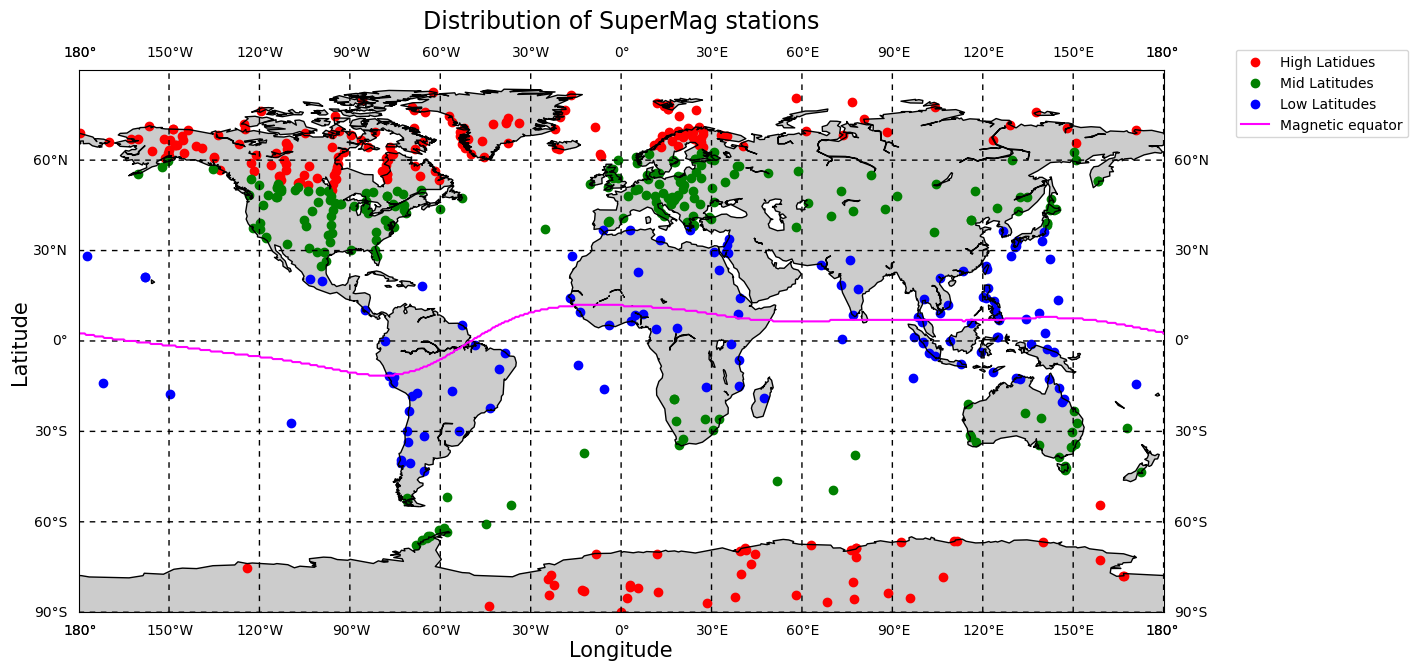

In [7]:

fig, ax = plt.subplots(figsize=(14,14))
# img=mpimg.imread('world_map.jpg')
# ax.imshow(img, extent=[-180,180,-90,90])
m = Basemap()
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black')
m.fillcontinents()
m.drawmeridians(range(0, 360, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 1, 1])
m.drawparallels(range(-90, 90, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 1, 0, 0])
# m.drawcountries()




# print(w_lon)
# if w_lon >= 180:
#     w_lon -= 360
#     e_lon -= 360

# for i in range(len(lons)):
#     if lons[i] >= 180:
#         lons[i] -= 360


# ax.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")
ax.scatter(high_lats["GLongg"].values, high_lats["GLAT"].values, c="red", label="High Latidues")
ax.scatter(mid_lats["GLongg"].values, mid_lats["GLAT"].values, c="green", label="Mid Latitudes")
ax.scatter(low_lats["GLongg"].values, low_lats["GLAT"].values, c="blue", label="Low Latitudes")
ax.plot(xspace,euator, color="magenta",label="Magnetic equator")

ax.legend(bbox_to_anchor=(1.06, 1.05))# ax.set_xlim(-180,180)
# ax.set_ylim(-90, 90)
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)

# plt.xlabel("Longitude (Deg)")
# plt.ylabel("Latitude (Deg)")
plt.title(f"Distribution of SuperMag stations", fontsize=17, pad=30)
plt.savefig("good_locs.png", bbox_inches='tight')

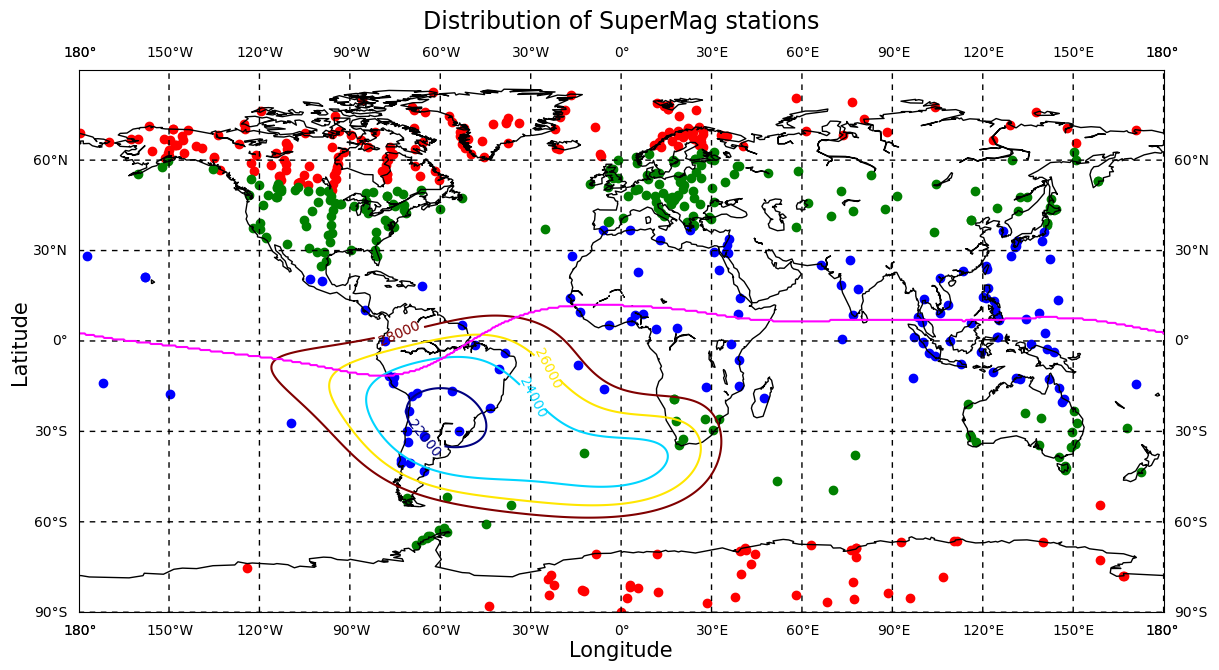

In [8]:
# Run the previous cells before running this one!
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle


fig, ax = plt.subplots(figsize=(14,14))
# img=mpimg.imread('world_map.jpg')
# ax.imshow(img, extent=[-180,180,-90,90])


m = Basemap()
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black')
# m.fillcontinents()
m.drawmeridians(range(0, 360, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 1, 1])
m.drawparallels(range(-90, 90, 30), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 1, 0, 0])
# m.drawcountries()




# print(w_lon)
# if w_lon >= 180:
#     w_lon -= 360
#     e_lon -= 360

# for i in range(len(lons)):
#     if lons[i] >= 180:
#         lons[i] -= 360
# ax.legend(bbox_to_anchor=(1.06, 1.05))# ax.set_xlim(-180,180)
# ax.set_ylim(-90, 90)
levels = np.arange(22000,30000,2000)
# levels = np.arange(22000, 30000, 40000)
CS = ax.contour(xspace, yspace,magnt, levels=levels, cmap='jet')
# manual_locations = [
#     (21000, 24000)]
ax.clabel(CS, inline=True, fontsize=10)#, manual=manual_locations)
# ax.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")
ax.scatter(high_lats["GLongg"].values, high_lats["GLAT"].values, c="red", label="High Latidues")
ax.scatter(mid_lats["GLongg"].values, mid_lats["GLAT"].values, c="green", label="Mid Latitudes")
ax.scatter(low_lats["GLongg"].values, low_lats["GLAT"].values, c="blue", label="Low Latitudes")
ax.plot(xspace,euator, color="magenta",label="Magnetic equator")


plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)

# plt.xlabel("Longitude (Deg)")
# plt.ylabel("Latitude (Deg)")
plt.title(f"Distribution of SuperMag stations", fontsize=17, pad=30)
plt.savefig("good_locs.png", bbox_inches='tight')

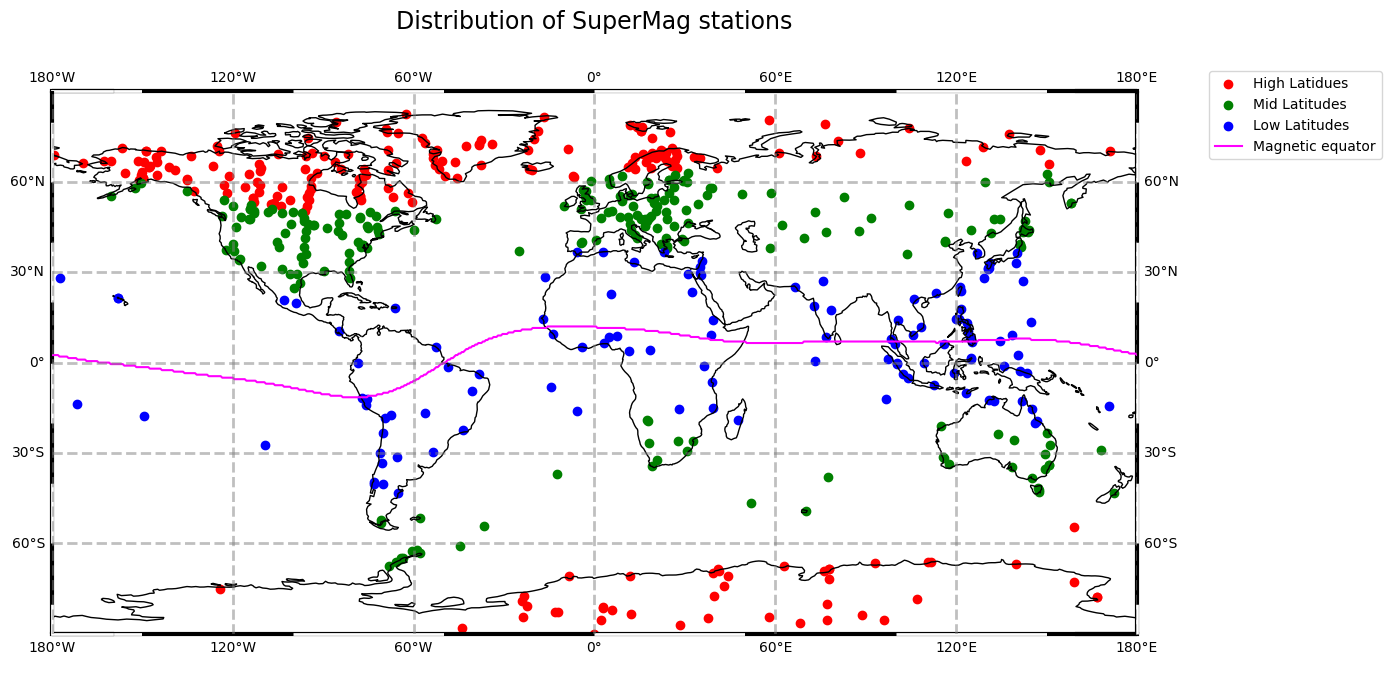

In [20]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

crs = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(projection=crs)

ax.coastlines()
ax.set_extent((-180, 180, -90, 90))
# ax.set_xticks((-180, -180, -90, -90))
# ax.set_yticks((25, 30, 35, 40))

add_zebra_frame(ax, crs=crs)

gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# ax.clabel(CS, inline=True, fontsize=10)#, manual=manual_locations)
# ax.scatter(all_stations["GLongg"].values, all_stations["GLAT"].values, c="red")
ax.scatter(high_lats["GLongg"].values, high_lats["GLAT"].values, c="red", label="High Latidues")
ax.scatter(mid_lats["GLongg"].values, mid_lats["GLAT"].values, c="green", label="Mid Latitudes")
ax.scatter(low_lats["GLongg"].values, low_lats["GLAT"].values, c="blue", label="Low Latitudes")
ax.plot(xspace,euator, color="magenta",label="Magnetic equator")

ax.legend(bbox_to_anchor=(1.06, 1.05))# ax.set_xlim(-180,180)

plt.title(f"Distribution of SuperMag stations", fontsize=17, pad=30)
plt.savefig("good_locs.png", bbox_inches='tight')

In [9]:
import itertools
from matplotlib.patheffects import Stroke, Normal
import numpy as np
import cartopy.mpl.geoaxes

def zebra_frame(self, lw=3, crs=None, zorder=None, iFlag_outer_frame_in = None):    
    # Alternate black and white line segments
    bws = itertools.cycle(["k", "w"])
    self.spines["geo"].set_visible(False)
    
    if iFlag_outer_frame_in is not None:
        #get the map spatial reference        
        left, right, bottom, top = self.get_extent()
        crs_map = self.projection
        xticks = np.arange(left, right+(right-left)/9, (right-left)/8)
        yticks = np.arange(bottom, top+(top-bottom)/9, (top-bottom)/8)
        #check spatial reference are the same           
        pass
    else:        
        crs_map =  crs
        xticks = sorted([*self.get_xticks()])
        xticks = np.unique(np.array(xticks))        
        yticks = sorted([*self.get_yticks()])
        yticks = np.unique(np.array(yticks))        

    for ticks, which in zip([xticks, yticks], ["lon", "lat"]):
        for idx, (start, end) in enumerate(zip(ticks, ticks[1:])):
            bw = next(bws)
            if which == "lon":
                xs = [[start, end], [start, end]]
                ys = [[yticks[0], yticks[0]], [yticks[-1], yticks[-1]]]
            else:
                xs = [[xticks[0], xticks[0]], [xticks[-1], xticks[-1]]]
                ys = [[start, end], [start, end]]

            # For first and last lines, used the "projecting" effect
            capstyle = "butt" if idx not in (0, len(ticks) - 2) else "projecting"
            for (xx, yy) in zip(xs, ys):
                self.plot(xx, yy, color=bw, linewidth=max(0, lw - self.spines["geo"].get_linewidth()*2), clip_on=False,
                    transform=crs_map, zorder=zorder, solid_capstyle=capstyle,
                    # Add a black border to accentuate white segments
                    path_effects=[
                        Stroke(linewidth=lw, foreground="black"),
                        Normal(),
                    ],
                )

setattr(cartopy.mpl.geoaxes.GeoAxes, 'zebra_frame', zebra_frame)